In [107]:
from astroquery.utils.tap.core import TapPlus
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('..')

from astroLuSt.database_interface import alerceinterface as aldiai
from astroLuSt.database_interface import database_utils as aldidu
from astroLuSt.database_interface import eleanorinterface as aldiei
from astroLuSt.database_interface import gaiainterface as aldigi
from astroLuSt.database_interface import lightkurveinterface as aldili
from astroLuSt.database_interface import simbadinterface as aldisi

import importlib
importlib.reload(aldiai)
importlib.reload(aldidu)
importlib.reload(aldiei)
importlib.reload(aldigi)
importlib.reload(aldili)
importlib.reload(aldisi)

#style for plotting
plt.style.use('astroLuSt.styles.LuSt_style')



In [97]:
targets = [
    'KIC 5006817', 'RR Lyr', 'TV Boo', 'KIC 5006817'
]

# SimbadDatabaseInterface

In [98]:
importlib.reload(aldisi)

SDI = aldisi.SimbadDatabaseInterface(
    simbad_timeout=120,
    npartitions=1,
    verbose=3,
)
print(SDI)
df_ids = SDI.extract_ids(
    input_ids=targets,
    show_scanned_strings_at=[1],
    verbose=None,
    parallel_kwargs=dict(n_jobs=4),
)

tics = df_ids['TIC']
print(tics)

df_ids

SimbadDatabaseInterface(
    npartitions=1,
    simbad_timeout=120,
    verbose=3,
)
INFO(extract_ids): Working on partition 1/1
INFO(match_ids_): Catalog is `None`. Corresponding id: `"KOI-5112"`
    INFO(match_ids_): Scanned Target: RR Lyr
    INFO(match_ids_): Query Result: HD 182989|AG+42 1698|AN   34.1901|AP J19252793+4247040|ASCC  425414|BD+42  3338|GAT  791|GC 26836|GCRV 11873|GEN# +1.00182989|G 125-7|GSC 03142-00494|HIC  95497|HIP 95497|KIC 7198959|LSPM J1925+4247|LTT 15677|2MASS J19252793+4247040|NLTT 47799|NSVS   5543125|PLX 4550|PLX 4550.00|PPM  58291|SAO  48421|SKY# 36151|SV* HV   180|TD1 24704|TIC 159717514|TYC 3142-494-1|USNO-B1.0 1327-00425262|USNO 886|uvby98 100182989|V* RR Lyr|WEB 16701|Gaia DR3 2125982599343482624|Gaia DR2 2125982599341232896
INFO(match_ids_): Catalog is `None`. Corresponding id: `"G 125-7"`
0    122447138
1    159717514
2    168709463
Name: TIC, dtype: object


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:    0.0s finished


,input_id,main_id,ra,dec,TYC,AP,KIC,2MASS,TIC,Gaia DR3,...,SV* HV,TD1,USNO-B1.0,USNO,uvby98,V* RR,WEB,CSI,uvby98 650902022,V* TV
0,KIC 5006817,KOI-5112,19 21 49.4321,+40 08 44.635,3138-1561-1,J19214942+4008446,5006817,J19214942+4008446,122447138,2101103743584479744,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RR Lyr,V* RR Lyr,19 25 27.9129,+42 47 03.693,3142-494-1,J19252793+4247040,7198959,J19252793+4247040,159717514,2125982599343482624,...,180,24704,1327-00425262,886,100182989,Lyr,16701,NaN,NaN,NaN
2,TV Boo,V* TV Boo,14 16 36.5814,+42 21 35.712,3038-699-1,J14163658+4221356,NaN,J14163658+4221356,168709463,1492230556717187456,...,NaN,NaN,NaN,NaN,NaN,NaN,12148,+42-14146,V,Boo


# EleanorDatabaseInterface

INFO(EleanorDatabaseInterface.download()): Extracting chunk 1/1 (1/1)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


Found star in Sector(s) 1 2 28 29
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-0902-0970_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-0902-0970_tess_v2_bkg.fits with expected size 78955200. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-0902-0970_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-0902-0970_tess_v2_pc.fits with expected size 158022720. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0001-3-1-cal-0902-0970_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0001-3-1_tess_v2_pm.txt with expected size 237794. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0002-3-2-cal-1196-0970_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0002-3-2-cal-1196-0970_tess_v2_bkg.fits with expected size 76674240. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ff

No eleanor postcard has been made for your target (yet). Using TessCut instead.
No eleanor postcard has been made for your target (yet). Using TessCut instead.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


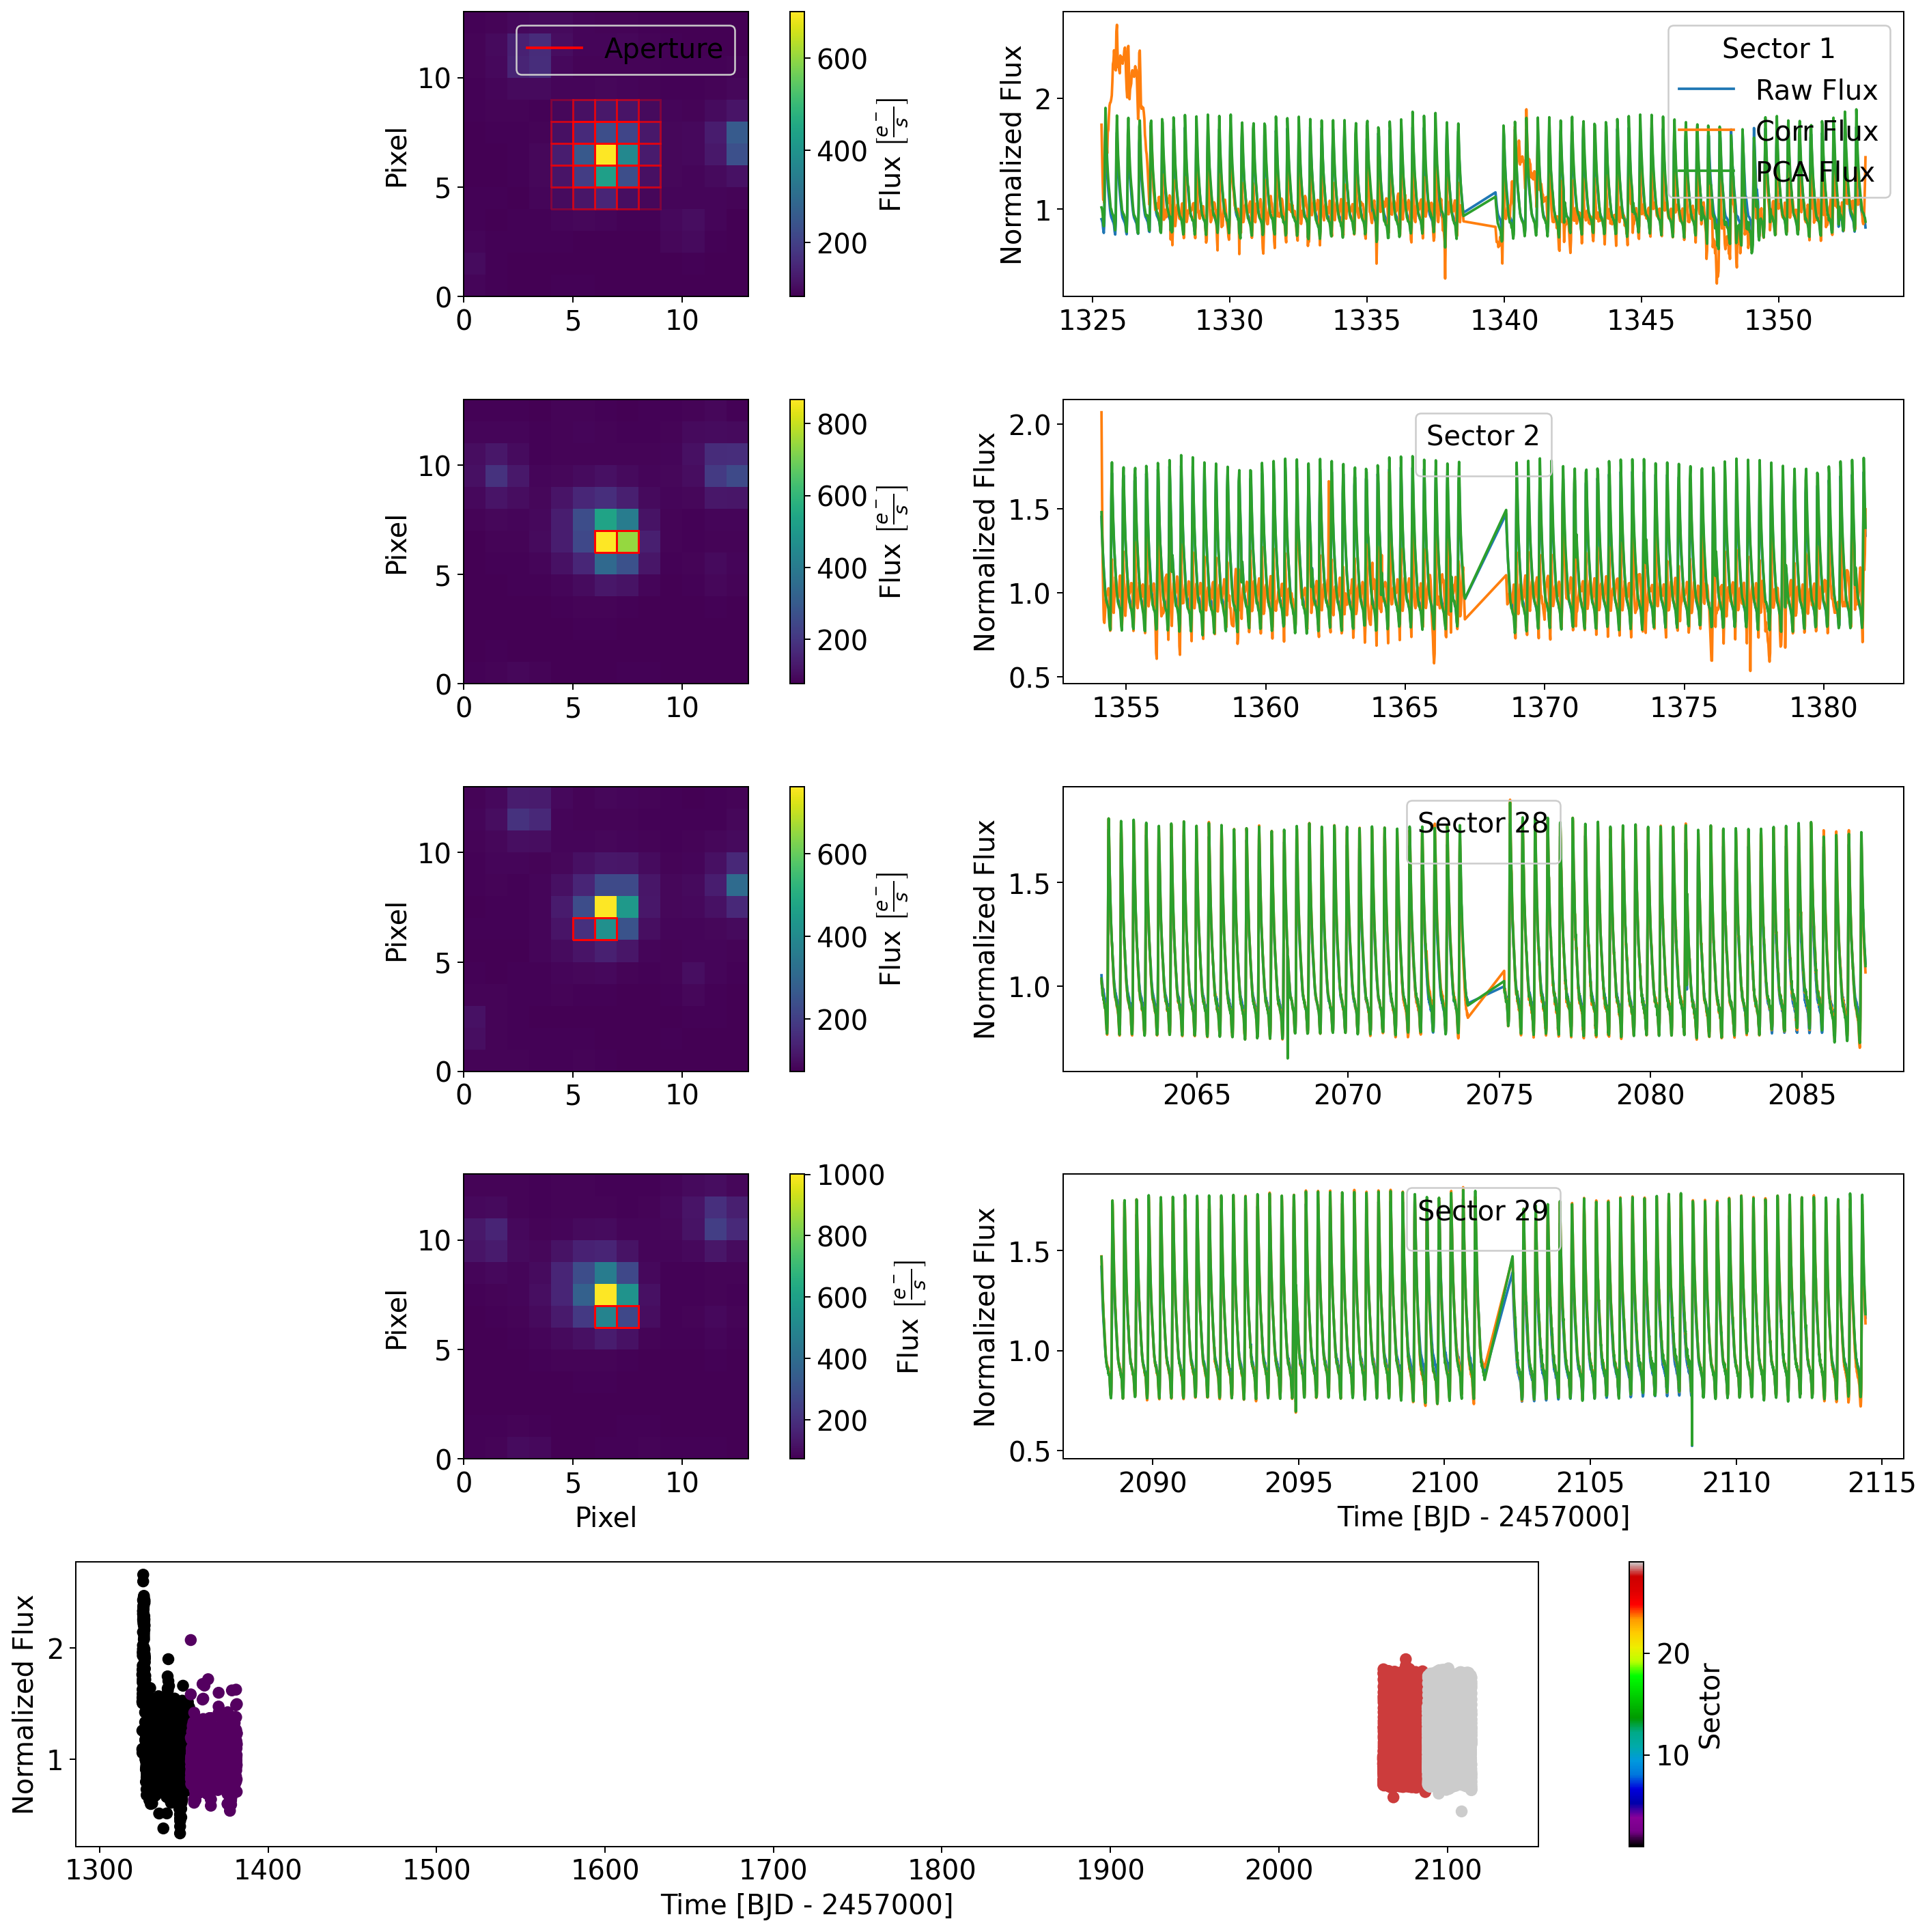

,tic,gaia,ra,dec,sector,tess_mag,aperture_size,chip,camera
0,234507163,4710156463040888192,12.502571,-62.635425,1,11.9841,17.015625,1,3
1,234507163,4710156463040888192,12.502571,-62.635425,2,11.9841,2.000000,2,3
2,234507163,4710156463040888192,12.502571,-62.635425,28,11.9841,2.000000,1,3
3,234507163,4710156463040888192,12.502571,-62.635425,29,11.9841,2.000000,2,3


In [115]:
importlib.reload(aldiei)

EDI = aldiei.EleanorDatabaseInterface(
    n_jobs=2,
    redownload=True,
    verbose=3,
)

lcs, metas, tpfs, aperture_masks = EDI.download(
    # sectors=[14],
    sectors='all',
    # source_ids=[{'tic':tic} for tic in tics[:]],
    source_ids=[{'tic':'234507163'}],
    # source_ids=[{'gaia': '2249474965068982272'}],
    # source_ids=[{'gaia': '2249474965068982272'}, {'gaia': '114797397716085120'}],
    get_normalized_flux=True, normfunc=lambda x, datum: x/np.nanmedian(x[datum.quality == 0]),
    tpfs2store=slice(1), store_aperture_masks=True,
    # tpfs2store=None, store_aperture_masks=True,
    n_chunks=1,
    # targetdata_kwargs=dict(do_pca=True, aperture_mode='small'),
    targetdata_kwargs=dict(do_pca=True),
    # custom_aperture_kwargs=dict(shape='rectangle', h=3, w=4), #in case you want to use a custom aperture
    # save_kwargs=dict(directory='./data/', pd_savefunc='to_parquet', store_metadata=True),
    save_kwargs=dict(directory=None, pd_savefunc='to_parquet', store_metadata=True),
)

fig, axs = EDI.plot_result(
    lcs=lcs[0],
    tpfs=tpfs[0],
    aperture_masks=aperture_masks[0],
)

plt.show()

pd.DataFrame(metas[0])

# GaiaDatabaseInterface

dict_keys(['EPOCH_PHOTOMETRY-Gaia DR3 1492230556717187456.xml', 'EPOCH_PHOTOMETRY-Gaia DR3 2125982599343482624.xml'])
Index(['source_id', 'transit_id', 'band', 'time', 'mag', 'flux', 'flux_error',
       'flux_over_error', 'rejected_by_photometry', 'rejected_by_variability',
       'other_flags', 'solution_id'],
      dtype='object')
band
G     40
BP    39
RP    39
Name: count, dtype: int64


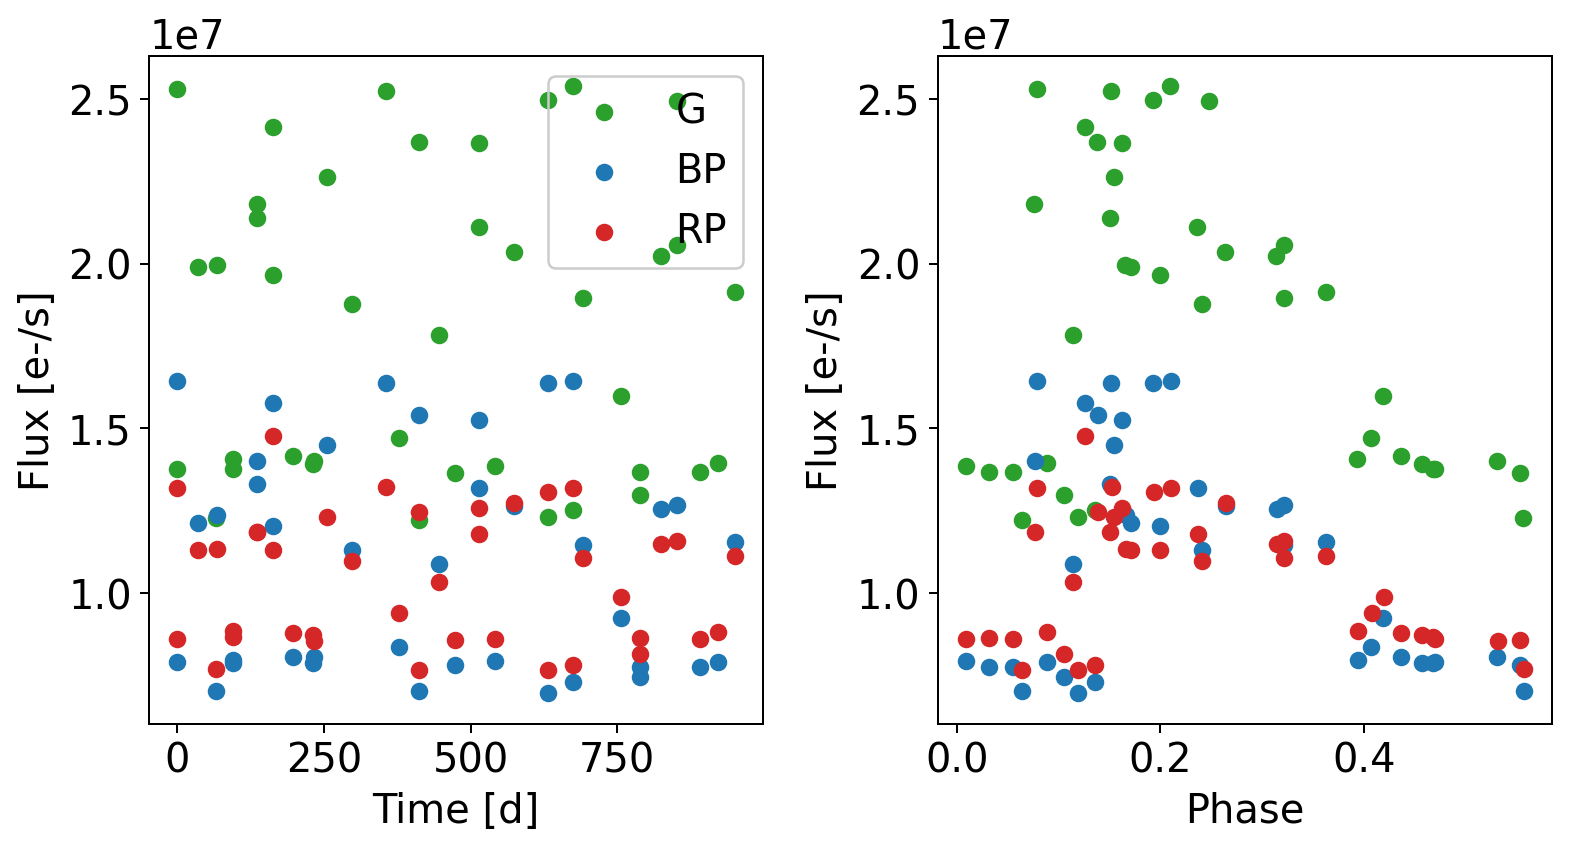

In [103]:
importlib.reload(aldigi)

GDI = aldigi.GaiaDatabaseInterface(gaia_class=Gaia)


# filter = "(jobs['phase'] == 'ERROR')"
# GDI.remove_all_jobs(pd_filter=filter, login_before=False, logout_after=False)


# print(df_ids.keys)
res = GDI.get_datalink(
    ids=df_ids['Gaia DR3'],
    retrieval_type=['EPOCH_PHOTOMETRY'],
    # retrieval_type=['ALL'],
    load_data_kwargs=dict(
        data_release='Gaia DR3',
    ),
    save_kwargs=dict(directory='./data/')
)


df = res[list(res.keys())[1]]
print(res.keys())

print(df.columns)


print(df['band'].value_counts())

df['phase'] = df['time']%0.56666
df['time'] -= df['time'].min()

fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.scatter(*df.query('band=="G"')[[ 'time', 'flux']].values.T, c='tab:green', label='G')
ax1.scatter(*df.query('band=="BP"')[['time', 'flux']].values.T, c='tab:blue',  label='BP')
ax1.scatter(*df.query('band=="RP"')[['time', 'flux']].values.T, c='tab:red',   label='RP')
ax2.scatter(*df.query('band=="G"')[[ 'phase', 'flux']].values.T, c='tab:green', label='G')
ax2.scatter(*df.query('band=="BP"')[['phase', 'flux']].values.T, c='tab:blue',  label='BP')
ax2.scatter(*df.query('band=="RP"')[['phase', 'flux']].values.T, c='tab:red',   label='RP')

ax1.set_xlabel('Time [d]')
ax2.set_xlabel('Phase')
ax1.set_ylabel('Flux [e-/s]')
ax2.set_ylabel('Flux [e-/s]')
ax1.legend()


# print(res)


# AlerceDatabaseInterface

In [ ]:
importlib.reload(aldiai)

ADI = aldiai.AlerceDatabaseInterface()

df = pd.DataFrame(
    data=np.array([
        [10054,	12.39495833, 27.02213889,],
        # [10088,	353.7751667, np.inf,],#41.10291667,],
        [10140,	16.294625,	 34.21841667,],
        # [10147,	359.6756667, 41.48880556,],
    ]),
    columns=['id', 'ra', 'dec']
)

df_ztf = ADI.crossmerge_by_coordinates(
    df_left=df,
    ra_colname='ra', dec_colname='dec', radius=1,
    sleep=2E-3,
    n_jobs=1, verbose=2
)

print(ADI.df_error_msgs_crossmerge)

ADI.download_lightcurves(
    df_ztf['oid_ztf'],
    save=False,
    # save='./data/',
    redownload=False,
    plot_result=True, save_plot=False, close_plots=False,
    sleep=2E-3,
    n_jobs=1, verbose=2
)
print(ADI.df_error_msgs_lcdownload)

# LightkurveInterface

In [ ]:

importlib.reload(aldili)
LKI = aldili.LightkurveInterface(
    tics=tics.astype(np.float64)
)

LKI.download_lightcurves_tess(
    #saving data
    save=False,
    sectors='all',
    quality_expression="(datum.quality == 0)",
    include_aperture=False, include_tpf=False,
    #plotting
    plot_result=True,
    aperture_detail=50, ylims=None,
    fontsize=16, figsize=(16,9),
    save_plot=False,
    sleep=0,
    n_jobs=1, n_chunks=1,
    verbose=2
)

print(LKI.df_extraction_summary)

# Utility Functions

In [113]:
importlib.reload(aldidu)

df = pd.DataFrame(data={
    'id':[
        4295806720, 38655544960, 343597448960,
        549755818112, 828929527040, 1275606125952,
        1340029955712, 1374389600384, 1619203481984,
        1653563247744, 2199023259904, 2546916445184,
        2851858288640, 2920577765120, 2989297243776,
        3062312520192, 3332894779520, 3371550165888,
    ]
})
query = f"""
    SELECT ut.*, sh.Source
    FROM upload_table AS ut INNER JOIN
        "I/354/starhorse2021" AS sh
            ON ut.id = sh.Source
"""


tap = TapPlus(
    url='http://tapvizier.cds.unistra.fr/TAPVizieR/tap',
    tap_context=None,
    verbose=True,
)

df_res = aldidu.query_upload_table(
    tap=tap, query=query,
    df_upload=df,
    upload_table_name='upload_table',
    nsplits=3,
    parallel_kwargs=dict(n_jobs=3, verbose=3),
    launch_job_async_kwargs=dict(verbose=False),

)

df_res

Created TAP+ (v20200428.1) - Connection:
	Host: tapvizier.cds.unistra.fr
	Use HTTPS: False
	Port: 80
	SSL Port: 443


/home/lukas/venvs/astroLuSt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]
INFO: Query finished. [astroquery.utils.tap.core]


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.2s finished


,id,Source
0,4295806720,4295806720
1,38655544960,38655544960
2,343597448960,343597448960
3,549755818112,549755818112
4,828929527040,828929527040
5,1275606125952,1275606125952
0,1340029955712,1340029955712
1,1374389600384,1374389600384
2,1619203481984,1619203481984
3,1653563247744,1653563247744
